In [1]:
import os
import dgl
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import random
import json
import matplotlib.pyplot as plt

In [2]:
# Process Cora
# 将节点ID映射成连续整数序号，并按序号生成连接信息
cora_dir = "./datasets/cora/"
nodes_id_map = {}               # 定义一个字典 nodes_id_map，用于记录节点的ID和其在图中的序号
start = 0                       # 定义一个变量 start，表示从0开始标记节点序号
start_list, target_list = [], []
with open(cora_dir+"cora.cites") as f:          # 打开边列表文件 cora.cites
    for ln in f:                # 对文件中的每一行执行
        ln = ln.strip("\n").split("\t")    # 去除行末的换行符，并将该行按制表符分割为两个元素，即边的起点和终点节点的ID。
        start_i, target_i = int(ln[1]), int(ln[0])  # 获取节点ID
        if start_i not in nodes_id_map:      # 起点节点是否在nodes_id_map 中已有记录
            nodes_id_map[start_i] = start
            start += 1
        if target_i not in nodes_id_map:     # 终点节点是否在nodes_id_map 中已有记录
            nodes_id_map[target_i] = start
            start += 1 
        start_list.append(nodes_id_map[start_i])
        target_list.append(nodes_id_map[target_i])
        

feature_names = ["w_{}".format(ii) for ii in range(1433)]
column_names =  feature_names + ["subject"]    # cora.content文件列名（特征+类别）
node_data = pd.read_csv(os.path.join(cora_dir+"cora.content"), sep='\t', header=None, names=column_names)   

# 将Cora数据集中的7种类别字符串映射到数字标签
cora_label_map = {
      'Case_Based': 0,
      'Genetic_Algorithms': 1,
      'Neural_Networks': 2,
      'Probabilistic_Methods': 3,
      'Reinforcement_Learning': 4,
      'Rule_Learning': 5,
      'Theory': 6,
  }

# 构造cora_features和cora_labels 列表，可以按节点序号为索引获取各个节点的特征和类别
cora_features = [None for _ in range(len(nodes_id_map))]  
cora_labels = [None for _ in range(len(nodes_id_map))]    
for i in range(node_data.shape[0]):
    feature_i, label_i = node_data.iloc[i][:-1], cora_label_map[node_data.iloc[i].tolist()[-1]]
    node_index_i = nodes_id_map[node_data.index[i]]
    cora_features[node_index_i] = feature_i
    cora_labels[node_index_i] = label_i

# 根据边列表和节点特征构建图
G_cora = dgl.DGLGraph()
G_cora.add_edges(start_list, target_list)
G_cora.ndata['feat'] = torch.Tensor(np.array(cora_features, dtype=np.float64))
G_cora.ndata['label'] = torch.Tensor(np.array(cora_labels)).type(torch.int64)

# 数据集划分
train_size = int(0.8*len(cora_labels))
val_size = int((len(cora_labels)-train_size)/2)

all_d = set([i for i in range(len(cora_labels))])
train_mask = set(random.sample(all_d, train_size))
val_mask = set(random.sample(all_d-train_mask, val_size))
test_mask = all_d-train_mask-val_mask

G_cora.ndata['train_mask'] = torch.Tensor(np.array([True if i in train_mask else False for i in range(len(all_d))])).type(torch.bool)
G_cora.ndata['val_mask'] = torch.Tensor(np.array([True if i in val_mask else False for i in range(len(all_d))])).type(torch.bool)
G_cora.ndata['test_mask'] = torch.Tensor(np.array([True if i in test_mask else False for i in range(len(all_d))])).type(torch.bool)



/data/sihua.qi/my_env/mypy36/lib/python3.7/site-packages/dgl/heterograph.py:72: DGLWarning: Recommend creating graphs by `dgl.graph(data)` instead of `dgl.DGLGraph(data)`.
  dgl_warning('Recommend creating graphs by `dgl.graph(data)`'


In [3]:
# Process CiteSeer
citeseer_dir = "./datasets/citeseer/"
nodes_id_map = {}
start_list, target_list = [], []
start = 0
node_data = pd.read_csv(os.path.join(citeseer_dir+"citeseer.content"), sep='\t', header=None)
node_data_id_set = set([str(i) for i in node_data[0].tolist()])
with open(citeseer_dir+"citeseer.cites") as f:
    for ln in f:
        ln = ln.strip("\n").split("\t")
        start_i, target_i = ln[1], ln[0]
        if start_i not in node_data_id_set or target_i not in node_data_id_set:
            continue
        if start_i not in nodes_id_map:
            nodes_id_map[start_i] = start
            start += 1
        if target_i not in nodes_id_map:
            nodes_id_map[target_i] = start
            start += 1 
        start_list.append(nodes_id_map[start_i])
        target_list.append(nodes_id_map[target_i])
       
citeseer_label_map = {
    "Agents": 0,
	"AI": 1,
	"DB": 2,
	"IR": 3,
	"ML": 4,
    "HCI": 5
}


citeseer_features = [None for _ in range(len(nodes_id_map))]
citeseer_labels = [None for _ in range(len(nodes_id_map))]
for i in range(node_data.shape[0]):
    tmp_i = node_data.iloc[i].tolist()
    feature_i, label_i = tmp_i[1:-1], citeseer_label_map[tmp_i[-1]]
    node_index_i = nodes_id_map[str(tmp_i[0])]
    citeseer_features[node_index_i] = feature_i
    citeseer_labels[node_index_i] = label_i

G_citeseer = dgl.DGLGraph()
G_citeseer.add_edges(start_list, target_list)
G_citeseer.ndata['feat'] = torch.Tensor(np.array(citeseer_features, dtype=np.float64))
G_citeseer.ndata['label'] = torch.Tensor(np.array(citeseer_labels)).type(torch.int64)

# 划分数据集（8:1:1）
train_size = int(0.8*len(citeseer_labels))
val_size = int((len(citeseer_labels)-train_size)/2)
all_d = set([i for i in range(len(citeseer_labels))])
train_mask = set(random.sample(all_d, train_size))
val_mask = set(random.sample(all_d-train_mask, val_size))
test_mask = all_d-train_mask-val_mask

G_citeseer.ndata['train_mask'] = torch.Tensor(np.array([True if i in train_mask else False for i in range(len(all_d))])).type(torch.bool)
G_citeseer.ndata['val_mask'] = torch.Tensor(np.array([True if i in val_mask else False for i in range(len(all_d))])).type(torch.bool)
G_citeseer.ndata['test_mask'] = torch.Tensor(np.array([True if i in test_mask else False for i in range(len(all_d))])).type(torch.bool)


G_citeseer_no_loop = dgl.DGLGraph()
no_loop_start = []
no_loop_target = []
for i in range(len(start_list)):
    if start_list[i] == target_list[i]:
        continue
    no_loop_start.append(start_list[i])
    no_loop_target.append(target_list[i])

G_citeseer_no_loop.add_edges(no_loop_start, no_loop_target)
G_citeseer_no_loop.ndata['feat'] = torch.Tensor(np.array(citeseer_features, dtype=np.float64))
G_citeseer_no_loop.ndata['label'] = torch.Tensor(np.array(citeseer_labels)).type(torch.int64)

train_size = int(0.8*len(citeseer_labels))
val_size = int((len(citeseer_labels)-train_size)/2)
all_d = set([i for i in range(len(citeseer_labels))])
train_mask = set(random.sample(all_d, train_size))
val_mask = set(random.sample(all_d-train_mask, val_size))
test_mask = all_d-train_mask-val_mask

G_citeseer_no_loop.ndata['train_mask'] = torch.Tensor(np.array([True if i in train_mask else False for i in range(len(all_d))])).type(torch.bool)
G_citeseer_no_loop.ndata['val_mask'] = torch.Tensor(np.array([True if i in val_mask else False for i in range(len(all_d))])).type(torch.bool)
G_citeseer_no_loop.ndata['test_mask'] = torch.Tensor(np.array([True if i in test_mask else False for i in range(len(all_d))])).type(torch.bool)



/data/sihua.qi/my_env/mypy36/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
# Process PPI
ppi_dir = "./datasets/ppi/"

ppi_class_map = json.load(open(ppi_dir+"ppi-class_map.json"))
ppi_graph = json.load(open(ppi_dir+"ppi-G.json"))
ppi_features = np.load(ppi_dir+"ppi-feats.npy")
ppi_id_map = json.load(open(ppi_dir+"ppi-id_map.json"))

ppi_labels = []
start_list, target_list = [], []
for i in ppi_graph["links"]:
    start_list.append(i["source"])
    target_list.append(i["target"])
for i in range(len(ppi_id_map)):
    ppi_labels.append(ppi_class_map[str(i)])

G_ppi = dgl.DGLGraph()
G_ppi.add_edges(start_list, target_list)
G_ppi.ndata['feat'] = torch.Tensor(np.array(ppi_features, dtype=np.float64))
G_ppi.ndata['label'] = torch.Tensor(np.array(ppi_labels)).type(torch.float32)


train_mask = [None for _ in range(len(ppi_id_map))]
val_mask = [None for _ in range(len(ppi_id_map))]
test_mask = [None for _ in range(len(ppi_id_map))]
for i in ppi_graph["nodes"]:
    if i["test"]:
        test_mask[i["id"]] = True
    else:
        test_mask[i["id"]] = False
    if i["val"]:
        val_mask[i["id"]] = True
    else:
        val_mask[i["id"]] = False
    if not val_mask[i["id"]] and not test_mask[i["id"]]:
        train_mask[i["id"]] = True
    else:
        train_mask[i["id"]] = False

G_ppi.ndata['train_mask'] = torch.Tensor(np.array(train_mask)).type(torch.bool)
G_ppi.ndata['val_mask'] = torch.Tensor(np.array(val_mask)).type(torch.bool)
G_ppi.ndata['test_mask'] = torch.Tensor(np.array(test_mask)).type(torch.bool)

In [5]:
from dgl.function import copy_src, sum as fn_sum
from dgl.utils import expand_as_pair


class GraphConv(nn.Module):
    def __init__(self, in_feats, out_feats, activation=None,):
        super(GraphConv, self).__init__()
        self._in_feats = in_feats
        self._out_feats = out_feats
        self.weight = nn.Parameter(torch.Tensor(in_feats, out_feats))
        self.bias = nn.Parameter(torch.Tensor(out_feats))
        torch.nn.init.xavier_uniform_(self.weight)
        torch.nn.init.zeros_(self.bias)

    def forward(self, graph, feat, weight=None):
        with graph.local_scope():
            aggregate_fn = copy_src('h', 'm')
            feat_src, feat_dst = expand_as_pair(feat, graph) # 获取 source 节点特征/target 节点特征
            degs = graph.out_degrees().float().clamp(min=1)   # 计算每个节点的出度，最小为1避免出现除0
            norm = torch.pow(degs, -0.5)      # normalized
            shp = norm.shape + (1,) * (feat_src.dim() - 1)
            norm = torch.reshape(norm, shp)
            feat_src = feat_src * norm
            weight = self.weight

            #按图结构进行卷积汇聚
            feat_src = torch.matmul(feat_src, weight)
            graph.srcdata['h'] = feat_src    # 存在图对象graph的srcdata属性中，属性名为'h'
            graph.update_all(aggregate_fn, fn_sum(msg='m', out='h'))  # 聚合
            rst = graph.dstdata['h']

            degs = graph.in_degrees().float().clamp(min=1)
            norm = torch.pow(degs, -0.5)
            shp = norm.shape + (1,) * (feat_dst.dim() - 1)
            norm = torch.reshape(norm, shp)
            rst = rst * norm
            rst = rst + self.bias

            return rst 


class GCN(nn.Module):
    def __init__(self, in_feats, h_feats, num_classes, layers=2, if_ppi=False, 
                 if_activate=True, if_normal=True, if_dropout=False):
        super(GCN, self).__init__()
        self.if_ppi = if_ppi
        self.layers = layers
        self.if_activate = if_activate
        self.if_dropout = if_dropout
        self.if_normal = if_normal
        if layers>2:
            self.linears = torch.nn.ModuleList([GraphConv(h_feats, h_feats) for _ in range(layers-2)])
        self.conv1 = GraphConv(in_feats, h_feats)
        self.conv2 = GraphConv(h_feats, num_classes)
        self.dropout = torch.nn.Dropout(p=0.5, inplace=False)

    def forward(self, g, in_feat):
        h = self.conv1(g, in_feat)
        if self.if_activate:
            h = F.relu(h)
        if self.layers > 2:
            for i, l in enumerate(self.linears):
                h = l(g, h)
        if self.if_activate:
            h = F.relu(h)
        if self.if_dropout:
            h = self.dropout(h)
        if self.if_normal:
            h = torch.nn.functional.normalize(h)
        h = self.conv2(g, h)
        if self.if_ppi:
            h = torch.nn.Sigmoid()(h)
        return h



In [9]:
def train(g, model, epochs=50, print_epoch=5, lr=0.01, if_ppi=False, print_loss=True):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    best_val_acc = 0
    best_test_acc = 0
    all_loss = []
    all_acc = []
    features = g.ndata['feat']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    val_mask = g.ndata['val_mask']
    test_mask = g.ndata['test_mask']
    for e in range(epochs):
        # Forward
        logits = model(g, features)

        # Compute prediction
        if not if_ppi:
            pred = logits.argmax(1)
            # Compute loss
            # Note that you should only compute the losses of the nodes in the training set.
            loss = F.cross_entropy(logits[train_mask], labels[train_mask])

            # Compute accuracy on training/validation/test
        else:
            loss = F.binary_cross_entropy(logits[train_mask], labels[train_mask])
            pred = (logits>=0.5) * 1.0

        all_loss.append(loss.detach().numpy())
        train_acc = (pred[train_mask] == labels[train_mask]).float().mean()
        val_acc = (pred[val_mask] == labels[val_mask]).float().mean()
        test_acc = (pred[test_mask] == labels[test_mask]).float().mean()
        all_acc.append(train_acc)  
        # Save the best validation accuracy and the corresponding test accuracy.
        if best_val_acc < val_acc:
            best_val_acc = val_acc
            best_test_acc = test_acc

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if e % print_epoch == 0:
            print('In epoch {}, loss: {:.3f}, val acc: {:.3f} (best {:.3f}), test acc: {:.3f} (best {:.3f})'.format(
                e, loss, val_acc, best_val_acc, test_acc, best_test_acc))
    if print_loss:
        plt.plot(all_loss, color="blue")
        plt.plot(all_acc, color="red")
        plt.show()  
    return best_val_acc, best_test_acc
# dataset = dgl.data.CoraGraphDataset(reverse_edge=False)
# G = dataset[0]


layers 2 hidden_features 16 if_activate True if_normal True if_dropout True
In epoch 0, loss: 1.946, val acc: 0.151 (best 0.151), test acc: 0.229 (best 0.229)
In epoch 50, loss: 1.058, val acc: 0.686 (best 0.738), test acc: 0.727 (best 0.694)
In epoch 100, loss: 0.736, val acc: 0.782 (best 0.797), test acc: 0.705 (best 0.694)

layers 2 hidden_features 16 if_activate True if_normal True if_dropout False
In epoch 0, loss: 1.920, val acc: 0.155 (best 0.155), test acc: 0.162 (best 0.162)
In epoch 50, loss: 0.775, val acc: 0.819 (best 0.834), test acc: 0.793 (best 0.786)
In epoch 100, loss: 0.465, val acc: 0.827 (best 0.834), test acc: 0.797 (best 0.786)

layers 2 hidden_features 16 if_activate True if_normal False if_dropout True
In epoch 0, loss: 1.961, val acc: 0.074 (best 0.074), test acc: 0.077 (best 0.077)
In epoch 50, loss: 0.320, val acc: 0.819 (best 0.852), test acc: 0.801 (best 0.793)
In epoch 100, loss: 0.214, val acc: 0.823 (best 0.856), test acc: 0.760 (best 0.815)

layers 2 hi

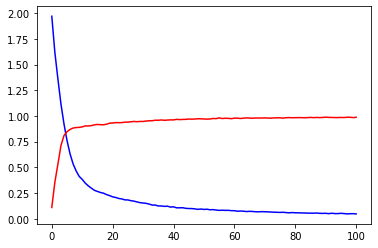

best test acc tensor(0.8155)


In [10]:
# Train Cora
lr = 0.01
layers = [2, 5]
best_param_cora = {"loop": None, "layers": None, "if_activate": None, "if_normal": None, "if_dropout": None, "acc": 0.0}
hidden_features = [16, 32, 64]
if_activate = [True, False]
if_normal = [True, False]
if_dropout = [True, False]

for h_f in hidden_features:
    for l in layers:
        for a in if_activate:
            for n in if_normal:
                for d in if_dropout:
                    print("layers", l, "hidden_features", h_f, "if_activate", a, "if_normal", n, "if_dropout", d)
                    model = GCN(G_cora.ndata['feat'].shape[1], h_f, len(cora_label_map), layers=l, if_activate=a, if_normal=n, if_dropout=d)
                    best_val_acc, _ = train(G_cora, model, epochs=101, print_epoch=50, lr=lr, print_loss=False)
                    if best_val_acc > best_param_cora["acc"]:
                        best_param_cora["layers"] = l
                        best_param_cora["if_activate"] = a
                        best_param_cora["if_dropout"] = d
                        best_param_cora["if_normal"] = n
                        best_param_cora["acc"] = best_val_acc
                    print()


# Best Param
print("Best Parameter")
print(best_param_cora)
l = best_param_cora["layers"]
a = best_param_cora["if_activate"]
n = best_param_cora["if_normal"]
d = best_param_cora["if_dropout"]

model = GCN(G_cora.ndata['feat'].shape[1], h_f, len(cora_label_map), layers=l, if_activate=a, if_normal=n, if_dropout=d)
_, best_test_acc = train(G_cora, model, epochs=101, print_epoch=25, lr=lr)
print("best test acc", best_test_acc)

layers 2 hidden_features 16 if_activate True if_normal True if_dropout True loop True
In epoch 0, loss: 1.820, val acc: 0.205 (best 0.205), test acc: 0.232 (best 0.232)
In epoch 50, loss: 0.927, val acc: 0.695 (best 0.749), test acc: 0.693 (best 0.741)
In epoch 100, loss: 0.664, val acc: 0.698 (best 0.749), test acc: 0.681 (best 0.741)

layers 2 hidden_features 16 if_activate True if_normal True if_dropout False loop True
In epoch 0, loss: 1.780, val acc: 0.199 (best 0.199), test acc: 0.244 (best 0.244)
In epoch 50, loss: 0.648, val acc: 0.752 (best 0.764), test acc: 0.735 (best 0.744)
In epoch 100, loss: 0.390, val acc: 0.737 (best 0.764), test acc: 0.714 (best 0.744)

layers 2 hidden_features 16 if_activate True if_normal False if_dropout True loop True
In epoch 0, loss: 1.800, val acc: 0.172 (best 0.172), test acc: 0.187 (best 0.187)
In epoch 50, loss: 0.352, val acc: 0.713 (best 0.764), test acc: 0.702 (best 0.702)
In epoch 100, loss: 0.217, val acc: 0.734 (best 0.764), test acc: 0

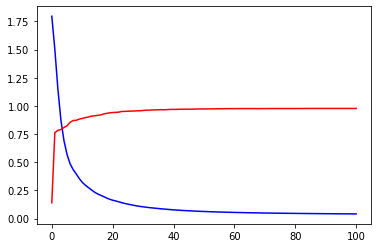

best test acc tensor(0.7470)


In [11]:
# Train Citeseer
lr = 0.01
layers = [2, 5]
Gs = [G_citeseer, G_citeseer_no_loop]
hidden_features = [16, 32, 64]
if_activate = [True, False]
if_normal = [True, False]
if_dropout = [True, False]
best_param_citeseer = {"loop": None, "layers": None, "if_activate": None, "if_normal": None, "if_dropout": None, "acc": 0.0}


for h_f in hidden_features:
    for g_tmp in Gs:
        if g_tmp == G_citeseer:
            loop = True
        else:
            loop = False             
        for l in layers:
            for a in if_activate:
                for n in if_normal:
                    for d in if_dropout:
                        print("layers", l, "hidden_features", h_f, "if_activate", a, "if_normal", n, "if_dropout", d, "loop", loop)
                        model = GCN(g_tmp.ndata['feat'].shape[1], h_f, len(citeseer_label_map), layers=l, if_activate=a, if_normal=n, if_dropout=d)
                        best_val_acc, _ = train(g_tmp, model, epochs=101, print_epoch=50, lr=lr, print_loss=False)
                        if best_val_acc > best_param_citeseer["acc"]:
                            best_param_citeseer["layers"] = l
                            best_param_citeseer["if_activate"] = a
                            best_param_citeseer["if_dropout"] = d
                            best_param_citeseer["if_normal"] = n
                            best_param_citeseer["acc"] = best_val_acc
                            best_param_citeseer["loop"] = loop
                            best_g = g_tmp
                        print()

# Best Param
print("Best Parameter")
print(best_param_citeseer)
l = best_param_citeseer["layers"]
a = best_param_citeseer["if_activate"]
n = best_param_citeseer["if_normal"]
d = best_param_citeseer["if_dropout"]
model = GCN(best_g.ndata['feat'].shape[1], h_f, len(citeseer_label_map), layers=l, if_activate=a, if_normal=n, if_dropout=d)
_, best_test_acc = train(best_g, model, epochs=101, print_epoch=50, lr=lr, print_loss=True)
print("best test acc", best_test_acc)

layers 2 hidden_features 16 if_activate True if_normal True if_dropout True
In epoch 0, loss: 0.693, val acc: 0.487 (best 0.487), test acc: 0.489 (best 0.489)
In epoch 50, loss: 0.583, val acc: 0.749 (best 0.749), test acc: 0.746 (best 0.746)
In epoch 100, loss: 0.566, val acc: 0.749 (best 0.750), test acc: 0.746 (best 0.746)

layers 2 hidden_features 16 if_activate True if_normal True if_dropout False
In epoch 0, loss: 0.695, val acc: 0.446 (best 0.446), test acc: 0.449 (best 0.449)
In epoch 50, loss: 0.583, val acc: 0.749 (best 0.749), test acc: 0.746 (best 0.746)
In epoch 100, loss: 0.566, val acc: 0.750 (best 0.750), test acc: 0.747 (best 0.747)

layers 2 hidden_features 16 if_activate True if_normal False if_dropout True
In epoch 0, loss: 0.693, val acc: 0.441 (best 0.441), test acc: 0.445 (best 0.445)
In epoch 50, loss: 0.585, val acc: 0.748 (best 0.749), test acc: 0.746 (best 0.746)
In epoch 100, loss: 0.567, val acc: 0.749 (best 0.749), test acc: 0.746 (best 0.746)

layers 2 hi

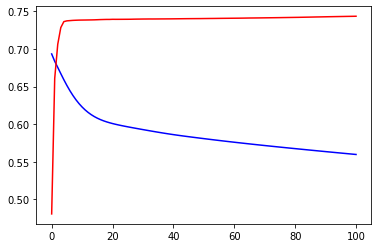

best test acc tensor(0.7488)


In [12]:
# Train PPI
lr = 0.01
layers = [2, 5]
hidden_features = [16, 32, 64]
if_activate = [True, False]
if_normal = [True, False]
if_dropout = [True, False]
best_param_ppi = {"loop": None, "layers": None, "if_activate": None, "if_normal": None, "if_dropout": None, "acc": 0.0}


for h_f in hidden_features:
    for l in layers:
        for a in if_activate:
            for n in if_normal:
                for d in if_dropout:
                    print("layers", l, "hidden_features", h_f, "if_activate", a, "if_normal", n, "if_dropout", d)
                    model = GCN(G_ppi.ndata['feat'].shape[1], h_f, len(ppi_labels[0]), layers=l, if_activate=a, if_normal=n, if_dropout=d, if_ppi=True)
                    best_val_acc, _ = train(G_ppi, model, epochs=101, print_epoch=50, lr=lr, print_loss=False, if_ppi=True)
                    if best_val_acc > best_param_ppi["acc"]:
                        best_param_ppi["layers"] = l
                        best_param_ppi["if_activate"] = a
                        best_param_ppi["if_dropout"] = d
                        best_param_ppi["if_normal"] = n
                        best_param_ppi["acc"] = best_val_acc
                        best_param_ppi["loop"] = loop
                    print()
                        
# Best Param
print("Best Parameter")
print(best_param_ppi)
l = best_param_ppi["layers"]
a = best_param_ppi["if_activate"]
n = best_param_ppi["if_normal"]
d = best_param_ppi["if_dropout"]
model = GCN(G_ppi.ndata['feat'].shape[1], h_f, len(ppi_labels[0]), layers=l, if_activate=a, if_normal=n, if_dropout=d, if_ppi=True)
_, best_test_acc = train(G_ppi, model, epochs=101, print_epoch=50, lr=lr, print_loss=True, if_ppi=True)
print("best test acc", best_test_acc)